In [30]:
# Standard imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

In [10]:
# -----------------------------
# Load Dataset
# -----------------------------
df = pd.read_csv("insurance.csv")
print(df.head())
print(df.info())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


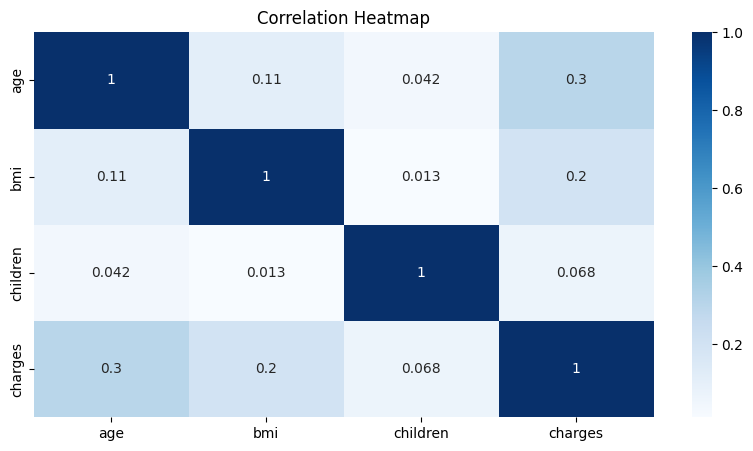

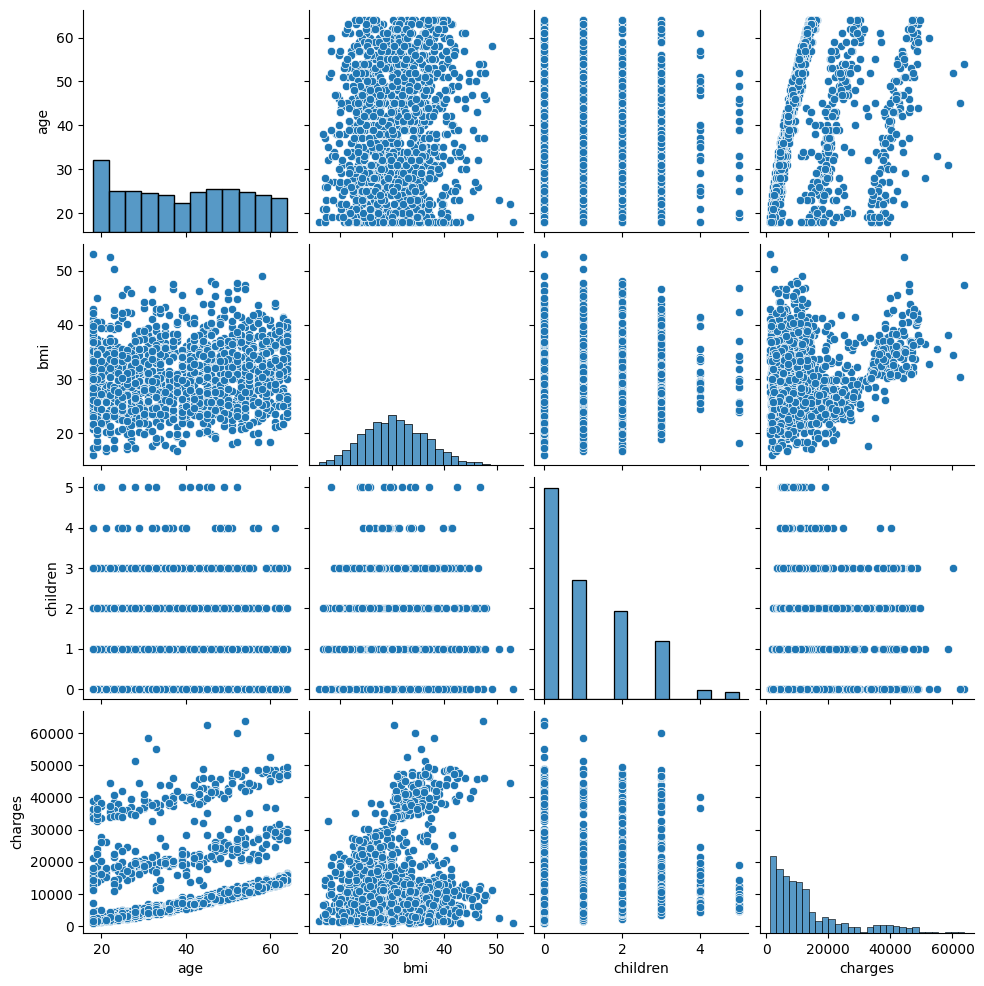

In [11]:
# -----------------------------
# Basic EDA
# -----------------------------
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="Blues")
plt.title("Correlation Heatmap")
plt.show()


sns.pairplot(df)
plt.show()

In [13]:
# -----------------------------
# One-hot Encoding
# -----------------------------
df_enc = pd.get_dummies(df, drop_first=True)

In [14]:
# Split features/target
X = df_enc.drop("charges", axis=1)
y = df_enc["charges"]


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# -----------------------------
# Linear Regression
# -----------------------------
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
pred_lr = lr.predict(X_test_scaled)


print("Linear Regression R2:", r2_score(y_test, pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, pred_lr)))

Linear Regression R2: 0.7835929767120722
Linear Regression RMSE: 5796.284659276274


In [16]:
# -----------------------------
# Ridge Regression
# -----------------------------
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
pred_ridge = ridge.predict(X_test_scaled)


print("Ridge R2:", r2_score(y_test, pred_ridge))
print("Ridge RMSE:", np.sqrt(mean_squared_error(y_test, pred_ridge)))

Ridge R2: 0.7835410749121385
Ridge RMSE: 5796.979691180858


In [17]:
# -----------------------------
# Lasso Regression
# -----------------------------
lasso = Lasso(alpha=0.001)
lasso.fit(X_train_scaled, y_train)
pred_lasso = lasso.predict(X_test_scaled)


print("Lasso R2:", r2_score(y_test, pred_lasso))
print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, pred_lasso)))

Lasso R2: 0.7835929495560636
Lasso RMSE: 5796.285022951974


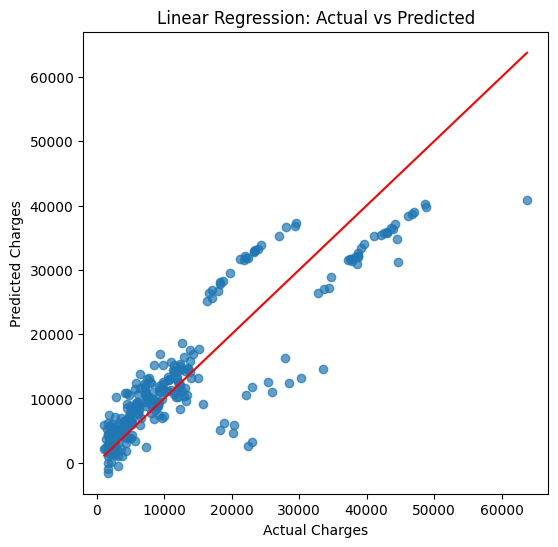

In [18]:
# -----------------------------
# Visualization: Actual vs Predicted
# -----------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test, pred_lr, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red")
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Linear Regression: Actual vs Predicted")
plt.show()

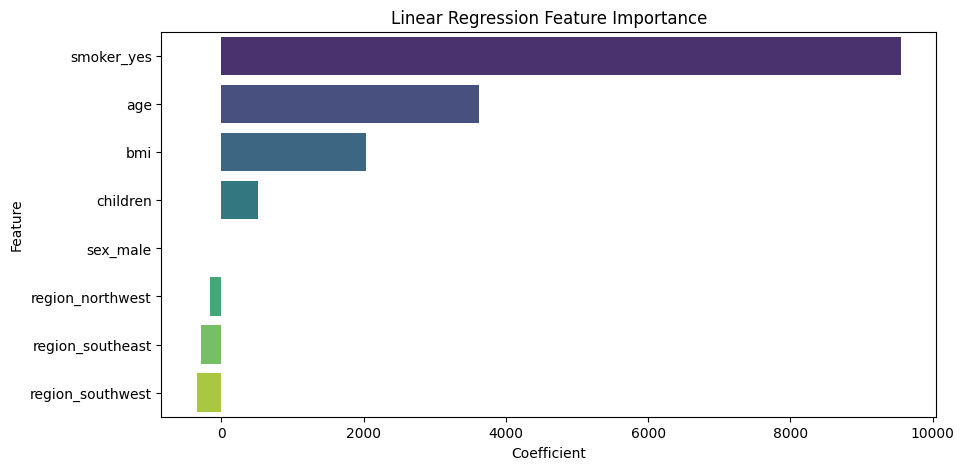

In [19]:
# -----------------------------
# Feature Importance (Coefficients)
# -----------------------------
coef_df = pd.DataFrame({"Feature": X.columns, "Coefficient": lr.coef_})
coef_df = coef_df.sort_values(by="Coefficient", ascending=False)


plt.figure(figsize=(10,5))
sns.barplot(data=coef_df, x="Coefficient", y="Feature", palette="viridis")
plt.title("Linear Regression Feature Importance")
plt.show()

Feature Selection (SelectKBest):
            Feature        Score
4        smoker_yes  2177.614868
0               age   131.174013
1               bmi    54.709308
6  region_southeast     7.352531
2          children     6.206037
3          sex_male     4.399702
7  region_southwest     2.499121
5  region_northwest     2.130837


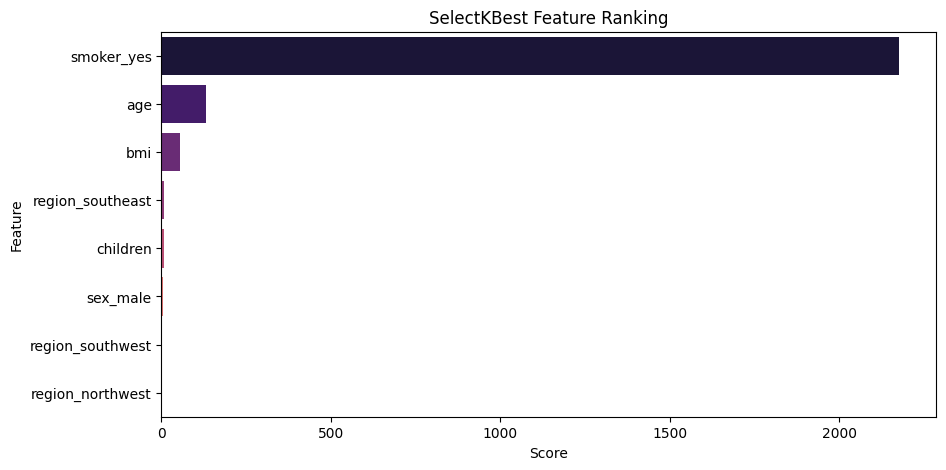

In [21]:
# -----------------------------
# Feature Selection: SelectKBest
# -----------------------------
selector = SelectKBest(score_func=f_regression, k="all")
selector.fit(X, y)


select_df = pd.DataFrame({"Feature": X.columns, "Score": selector.scores_})
select_df = select_df.sort_values(by="Score", ascending=False)


print("Feature Selection (SelectKBest):")
print(select_df)


plt.figure(figsize=(10,5))
sns.barplot(data=select_df, x="Score", y="Feature", palette="magma")
plt.title("SelectKBest Feature Ranking")
plt.show()

In [23]:
# -----------------------------
# Recursive Feature Elimination (RFE)
# -----------------------------
rfe_model = LinearRegression()
rfe = RFE(estimator=rfe_model, n_features_to_select=5)
rfe.fit(X_train_scaled, y_train)


rfe_df = pd.DataFrame({"Feature": X.columns, "Selected": rfe.support_})
print("RFE Selected Features:")
print(rfe_df[rfe_df["Selected"] == True])

RFE Selected Features:
            Feature  Selected
0               age      True
1               bmi      True
2          children      True
4        smoker_yes      True
7  region_southwest      True


In [24]:
# -----------------------------
# Cross-Validation
# -----------------------------
cv_score = cross_val_score(lr, X_train_scaled, y_train, cv=5)
print("Cross-validation scores:", cv_score)
print("Mean CV score:", np.mean(cv_score))

Cross-validation scores: [0.71585461 0.80210564 0.72296123 0.65784333 0.76678575]
Mean CV score: 0.7331101109097584


In [25]:
# -----------------------------
# Hyperparameter Tuning for Ridge & Lasso
# -----------------------------
ridge_params = {"alpha": [0.01, 0.1, 1, 5, 10, 20, 50]}
lasso_params = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 5]}


ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring="r2")
ridge_grid.fit(X_train_scaled, y_train)


lasso_grid = GridSearchCV(Lasso(max_iter=10000), lasso_params, cv=5, scoring="r2")
lasso_grid.fit(X_train_scaled, y_train)


print("Best Ridge Alpha:", ridge_grid.best_params_)
print("Best Lasso Alpha:", lasso_grid.best_params_)

Best Ridge Alpha: {'alpha': 10}
Best Lasso Alpha: {'alpha': 5}


In [26]:
best_ridge = ridge_grid.best_estimator_
best_lasso = lasso_grid.best_estimator_


# Evaluate
pred_ridge = best_ridge.predict(X_test_scaled)
pred_lasso = best_lasso.predict(X_test_scaled)


print("Ridge R2:", r2_score(y_test, pred_ridge))
print("Lasso R2:", r2_score(y_test, pred_lasso))

Ridge R2: 0.7830200444609896
Lasso R2: 0.7834545533183055


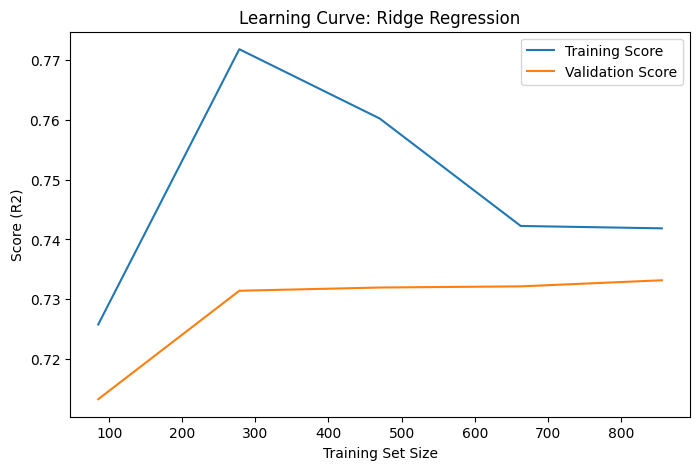

In [27]:
# -----------------------------
# Learning Curve (for Ridge)
# -----------------------------
train_sizes, train_scores, test_scores = learning_curve(best_ridge, X_train_scaled, y_train,
cv=5, train_sizes=np.linspace(0.1, 1.0, 5))


train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)


plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Validation Score")
plt.xlabel("Training Set Size")
plt.ylabel("Score (R2)")
plt.title("Learning Curve: Ridge Regression")
plt.legend()
plt.show()

In [39]:
# -----------------------------
# Save Model + Scaler using Pickle
# -----------------------------
model_package = {
"model": best_ridge,
"scaler": scaler,
"feature_names": X.columns.tolist()
}


with open("insurance_model.pkl", "wb") as f:
    pickle.dump(model_package, f)
    
print("Model saved as insurance_model.pkl")

Model saved as insurance_model.pkl


In [36]:
# -----------------------------
# Function to Predict on Unseen Data
# -----------------------------
def predict_unseen(new_data_dict):
    with open("insurance_model.pkl", "rb") as f:
        package = pickle.load(f)


    model = package["model"]
    scaler = package["scaler"]
    feature_names = package["feature_names"]
    
    
    new_df = pd.DataFrame([new_data_dict])
    new_df = pd.get_dummies(new_df)
    
    
    for col in feature_names:
        if col not in new_df:
            new_df[col] = 0
    
    
    new_df = new_df[feature_names]
    new_scaled = scaler.transform(new_df)
    prediction = model.predict(new_scaled)
    
    
    return prediction[0]


# Example unseen data
example = {
"age": 28,
"sex": "female",
"bmi": 23.4,
"children": 1,
"smoker": "no",
"region": "southwest"
}


print("Predicted Charge for Unseen Example:", predict_unseen(example))

Predicted Charge for Unseen Example: 2860.2071363208597
